<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA4/blob/master/Session14_RCNN%26DenseDepth/dataCreation_bg_fg_mask_depth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!nvidia-smi

Sun May 10 17:10:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |    865MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [30]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Import packages

In [0]:
import cv2
import os
from google.colab.patches import cv2_imshow
from skimage import io
import glob
import random
import numpy as np
from tqdm.autonotebook import tqdm, trange
import time
import shutil
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
# Configuring paths
# Raw background images containing square images.
raw_bg = './raw_bg'
# Raw foreground images
raw_fg = './raw_fg'
# 200 * 200 size background images
bg_images = './bg'
# Foreground images.
fg_images = './fg'
# Background with foreground images.
bg_fg_images = './bg_fg'
# Mask images.
mask_images = './mask'
# Monocular depth images.
depth_images = './depth'

# Foreground images resize height.
desired_h = 80
# Flag for colour/grayscale bg_fg images.
colour_flag = True

# DenseDepth
depth_batch_size = 500

gdrive_path = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

## Resizing images to desired resolutions.

Resizing square background images to desired resolution. Raw images are present on the mounted drive. 
Background image is resized to 192*192 and foreground image is resized to fixed height of 80 while keeping the aspect ratio. 

In [0]:
# To resize background and foreground images the first time, go to mounted drive. 
cd '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth


In [0]:
!ls '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

 bg					        fg
 bg_fg					        ImagePreparation.gsheet
'Copy of dataCreation-bg_fg_mask_depth.ipynb'   mask
 dataCreation-bg_fg_mask_depth.ipynb	        mask.zip
 DenseDepth				        raw_bg
 depth					        raw_fg


In [0]:
# Resize square images to 192 * 192 images for background.
paths = glob.glob(os.path.join(raw_bg,'*'))
paths.sort()
for path in paths:
    img = cv2.imread(path)
    file_name = path.split('/')[-1] 
    resized_img = cv2.resize(img, (192, 192), interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(bg_images,file_name), resized_img)

Resizing foreground to required height keeping aspect ratio constant.

In [0]:
paths = glob.glob(os.path.join(raw_fg,'*'))
paths.sort()

for path in paths:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    file_name = path.split('/')[-1]
    h, w = img.shape[:2]
    r = desired_h/float(h)
    dim = (desired_h, int(w * r))
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(fg_images,file_name), resized_img)

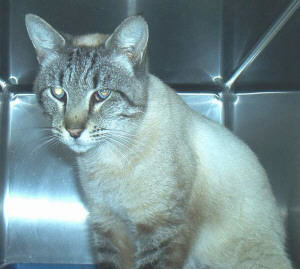

In [0]:
cv2_imshow(cv2.imread('./raw_fg/fg_050.png'))

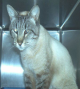

In [0]:
cv2_imshow(cv2.imread('./fg/fg_050.png'))

 ## Background and foreground image display.

In [0]:
def display_horizontal(img_paths, img_name):
    # img = []
    # horizontal_concat = []
    it = 0
    for img_path in img_paths:
        if it == 0:
            horizontal_concat = cv2.imread(img_path)
        else:
            img = cv2.imread(img_path)
            horizontal_concat = np.concatenate((horizontal_concat,img), axis = 1)
        it +=1
    cv2_imshow(horizontal_concat)
    cv2.imwrite(os.path.join(gdrive_path,results+str()+'.jpg'), horizontal_concat)

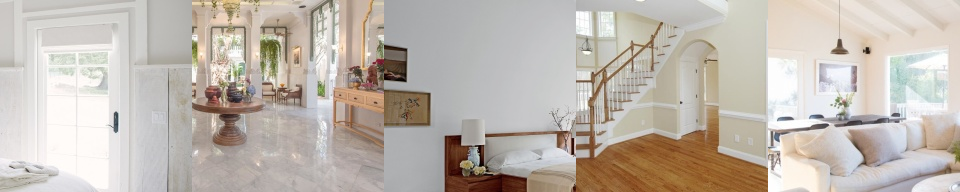

NameError: ignored

In [59]:
bg_im = glob.glob(os.path.join(bg_images,'*'))
display_horizontal(bg_im[:5],"background_images")

In [0]:
fg_im = glob.glob(os.path.join(bg_images,'*'))
display_horizontal(bg_im[:5])

## bg_fg and Mask creation

Move to local directory and copy bg and fg folders to local.

In [39]:
pwd

'/content'

In [40]:
ls

bg/  bg_fg/  fg/  mask/  mask.zip  sample_data/


In [0]:
cd /content

/content


In [0]:
fg_dir = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/fg'
shutil.copytree(fg_dir,"fg")

'fg'

In [0]:
bg_dir = '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/bg'
shutil.copytree(bg_dir,"bg")

'bg'

In [0]:
if os.path.exists("bg_fg"):
    shutil.rmtree("bg_fg")
if os.path.exists("mask"):
    shutil.rmtree("mask")

os.mkdir("bg_fg")
os.mkdir("mask")


In [0]:
ls

bg/  bg_fg/  fg/  mask/  sample_data/


In [0]:
bg_paths = glob.glob(os.path.join(bg_images,'*'))
fg_paths = glob.glob(os.path.join(fg_images,'*'))

# Sort bg and fg paths in ascending order to keep created bgfg and mask images in order.
bg_paths.sort()
fg_paths.sort()

# For each background image, prepare bg_fg and mask
# for bg_no, bg_path in enumerate(tqdm(bg_paths, 1)):
for bg_no, bg_path in tqdm(enumerate(bg_paths, 1), total = len(bg_paths), desc = 'Background Images'):
    background = cv2.imread(bg_path)
    bg_height, bg_width, bg_channels = background.shape
    
    # For each foreground image, prepare bg_fg and mask
    for fg_no, fg_path in tqdm(enumerate(fg_paths, 1), total = len(fg_paths), desc = 'Foreground Images', leave=False):
        # Read png image with transparency alpha channel as well.
        foreground_ = cv2.imread(fg_path, cv2.IMREAD_UNCHANGED)
        fg_height, fg_width, fg_channels = foreground_.shape
        i = 0

        # For each of normal and flipped foreground image, prepare fg_bg and mask
        for foreground in (foreground_, cv2.flip(foreground_, 1)):
            # alpha = 0 represents full transparency and max value indicates opaqueness.
            alpha_foreground = foreground[:,:,3] / 255.0
            alpha_background = 1 - alpha_foreground
            for j in range(0, 20):
                # For image overlay
                
                x_offset = random.randint(0, (bg_width - fg_width))
                y_offset = random.randint(0, (bg_height - fg_height))
                
                y1, y2 = y_offset, y_offset + fg_height
                x1, x2 = x_offset, x_offset + fg_width

                # For overlay
                overlay = background.copy()

                # For mask
                mask = np.zeros(background[:,:,0].shape)
                mask_fg = cv2.cvtColor(foreground[:,:,:3], cv2.COLOR_BGR2GRAY)
                mask_fg[:] = 255
                
                for c in range(0,3):    
                    overlay[y1:y2, x1:x2, c] = (alpha_foreground * foreground[:, :, c] + alpha_background * background[y1:y2, x1:x2, c])
                
                mask[y1:y2, x1:x2] = (alpha_foreground * mask_fg[:, :] + alpha_background * mask[y1:y2, x1:x2])
                
                if colour_flag:
                    # cv2.imwrite(os.path.join(bg_fg_images,"bgfg_b"+str(bg_no)+"_f"+str(fg_no)+"_"+str(i)+".jpg"), overlay)
                    cv2.imwrite(os.path.join(bg_fg_images,"bgfg_b"+str(bg_no).zfill(3)+"_f"+str(fg_no).zfill(3)+"_"+str(i)+".jpg"), overlay)
                else:
                    cv2.imwrite(os.path.join(bg_fg_images,"bgfg_b"+str(bg_no).zfill(3)+"_f"+str(fg_no).zfill(3)+"_"+str(i)+".jpg"), cv2.cvtColor(overlay[:,:,:3], cv2.COLOR_BGR2GRAY))
                
                cv2.imwrite(os.path.join(mask_images,"mask_b"+str(bg_no).zfill(3)+"_f"+str(fg_no).zfill(3)+"_"+str(i)+".jpg"), mask)
                i += 1
            


## Move bg_fg and mask to network drive

In [0]:
ls bg_fg | wc -l

400000


In [0]:
ls

bg/  bg_fg/  depth/  fg/  mask/  sample_data/


In [0]:
!pwd

/content


In [0]:
!zip -r -q bg_fg.zip bg_fg/

In [0]:
shutil.move("bg_fg.zip", gdrive_path)

'/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/bg_fg.zip'

In [0]:
!zip -r -q mask.zip mask/

In [0]:
shutil.move("mask.zip", gdrive_path)

Error: ignored

## Create Depth Images

In [0]:
cd '/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth'

/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth


In [0]:
# Import necessary packages
import os
import glob
import argparse
import matplotlib
import numpy as np
from PIL import Image
from skimage.transform import resize

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict, load_images, display_images
from matplotlib import pyplot as plt

denseDepth_model = 'DenseDepth/nyu.h5'

custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')
# Load model into GPU / CPU
model = load_model(denseDepth_model, custom_objects=custom_objects, compile=False)
print('\nModel loaded ({0}).'.format(denseDepth_model))

Using TensorFlow backend.


Loading model...

Model loaded (DenseDepth/nyu.h5).


In [0]:
cd /content

/content


In [0]:
ls

sample_data/


## If bg_fg is already created

Copy data from gdrive and process.

In [0]:
ls

sample_data/


In [0]:
shutil.move(os.path.join(gdrive_path,"bg_fg.zip"), os.getcwd())

FileNotFoundError: ignored

In [0]:
!unzip -q bg_fg.zip

In [0]:
shutil.rmtree("depth")

In [0]:
os.mkdir("depth")

In [0]:
ls

bg_fg/  bg_fg.zip  depth/  sample_data/


## Depth calculation begins

In [0]:
pwd

'/content'

In [0]:
bg_fg_paths = glob.glob(os.path.join(bg_fg_images,'*'))
bg_fg_paths.sort()
print(len(bg_fg_paths))
bg_fg_paths = bg_fg_paths[0:100000]
print(len(bg_fg_paths),"first file-", bg_fg_paths[0], "Last File-",bg_fg_paths[-1])

400000
100000 first file- ./bg_fg/bgfg_b001_f001_0.jpg Last File- ./bg_fg/bgfg_b025_f100_9.jpg


In [0]:
pbar = trange(0, len(bg_fg_paths), depth_batch_size)
for depth_image_id in pbar:
    # Take only batch size worth of bg_fg images.
    loaded_images = []
    bgfg_filename = []

    read_tic = time.time()
    for file in bg_fg_paths[depth_image_id: (depth_image_id + depth_batch_size)]:
        x = np.clip(np.asarray(Image.open( file ), dtype=float) / 255, 0, 1)
        x = resize(x, (576,576), Image.ANTIALIAS)
        loaded_images.append(x)
        bgfg_filename.append(file.split("bgfg")[-1])
    inputs = np.stack(loaded_images, axis=0)
    read_toc = time.time()

    model_tic = time.time()
    # Dense Depth prediction
    outputs = predict(model, inputs)
    model_toc = time.time()

    write_tic=time.time()
    for idx, output in enumerate(outputs):
        output_img = Image.fromarray((output[:, :, 0] * 255).astype(np.uint8))
        output_img.save(os.path.join(depth_images,"densedepth_"+bgfg_filename[idx]))
    write_toc = time.time()

    pbar_details = f'R={(read_toc-read_tic):0.2f} s - P={(model_toc-model_tic):0.2f} s - W={(write_toc-write_tic):0.2f} s'
    pbar.set_description(desc= pbar_details)



KeyboardInterrupt: ignored

In [0]:
ls

bg/  bg_fg/  depth/  fg/  mask/  sample_data/


In [0]:
!zip -r -q depth.zip depth/

In [0]:
shutil.move("depth.zip", gdrive_path)

'/gdrive/My Drive/ColabNotebooks/SchoolOfAI/Mask_RCNN_depth/depth.zip'

# THE END

In [0]:
loaded_images = []
x = np.clip(np.asarray(Image.open( './bg_fg/bg_fg_b1_f1_2.jpg' ), dtype=float) / 255, 0, 1)
x = resize(x, (576,576), Image.ANTIALIAS)
loaded_images.append(x)
inputs = np.stack(loaded_images, axis=0)

In [0]:
fname = './bg_fg/bgfg_b3_f1_0.jpg'.split('bgfg')
print(fname)

['./bg_fg/', '_b3_f1_0.jpg']


In [0]:
print(inputs.shape)

(11, 576, 576, 3)


In [0]:
outputs = predict(model, inputs)

In [0]:
# Output image is half of input.
print(outputs[0].shape)

(288, 288, 1)


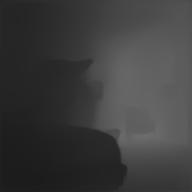

In [0]:
#576
cv2_imshow(resize(outputs[10]*255.0, (192,192), Image.ANTIALIAS))

In [0]:
for idx, output in enumerate(outputs):
    output_img = Image.fromarray((output[:, :, 0] * 255).astype(np.uint8))
    output_img.save(os.path.join(depth_images,"densedepth_"+str(idx)+"_.jpg"))

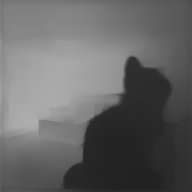

In [0]:
#384
cv2_imshow(resize(outputs[0]*255.0, (192,192), Image.ANTIALIAS))

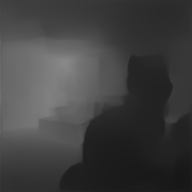

In [0]:
cv2_imshow(resize(outputs[0]*255.0, (192,192), Image.ANTIALIAS))

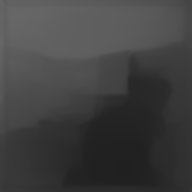

In [0]:
cv2_imshow(resize(outputs[2]*255.0, (192,192), Image.ANTIALIAS))

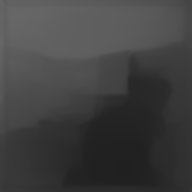

In [0]:
cv2_imshow(resize(outputs[2]*255.0, (192,192)))

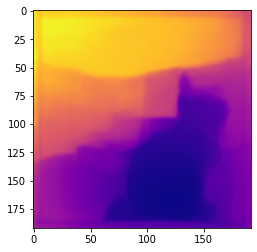

In [0]:
plt.imshow(out_img)

(192, 192, 1)


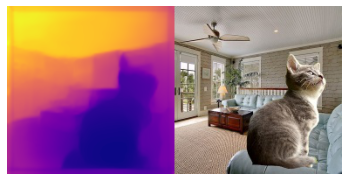

In [0]:
output, input = outputs[2], inputs[2]
output, input = resize(output, (192, 192)), resize(input, (192, 192))
print(output.shape)
plasma = plt.get_cmap('plasma')
rescaled = output[:,:,0]
rescaled = rescaled - np.min(rescaled)
rescaled = rescaled / np.max(rescaled)
out_img = plasma(rescaled)[:,:,:3]
img_set = np.hstack([out_img, input])
plt.figure()
plt.imshow(img_set)
plt.axis('off')
plt.grid('off')

In [0]:
img_1 = cv2.imread(img)
print(img_1.shape)

(480, 640, 3)


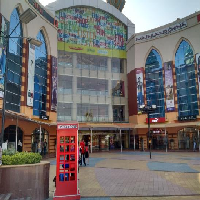

In [0]:
cv2_imshow(resized_img)

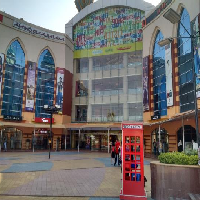

In [0]:
cv2_imshow(flip_h)

In [0]:
batch_size = 25
for i in range(0,133,25):
    for j in range(i,i+25):
        print(j, end = " ")
    print("\n")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 

75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 

125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 



In [0]:
for depth_image_id in range(0, len(bg_fg_paths), depth_batch_size):
    # Take only batch size worth of bg_fg images.
 
    for file in bg_fg_paths[depth_image_id: (depth_image_id + depth_batch_size)]:
        print(file.split("bgfg")[-1])
    break

_b1_f1_0.jpg
_b2_f1_0.jpg
_b3_f1_0.jpg
_b4_f1_0.jpg
_b5_f1_0.jpg
_b6_f1_0.jpg
_b7_f1_0.jpg
_b8_f1_0.jpg
_b9_f1_0.jpg
_b10_f1_0.jpg
_b11_f1_0.jpg


(70, 100, 4)


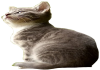

(70, 100, 4)


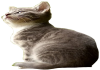

In [0]:
for foreground in (foreground, cv2.flip(foreground, 1)):
    print(foreground.shape)
    cv2_imshow(imag)